<a href="http://www.konradlorenz.edu.co/es/"><img src = "http://www.konradlorenz.edu.co/templates/openweb-j17/images/logo.png" width = 400> </a>

<h1 align=center><font size = 8>Proyecto Análisis de Accidentalidad de Transporte Público en Bogotá</font></h1>

__<span style="color:green;font-size:28px;">Autores:</span>__ <span style="font-size:28px;">Cindy Naranjo y Jairo Iván Ordóñez </span>

__<span style="color:green;font-size:28px;">Facultad:</span>__ <span style="font-size:28px;">Ingeniería</span>

__<span style="color:green;font-size:28px;">Programa:</span>__ <span style="font-size:28px;">Especialización Analítica Estratégica de Datos</span>

__<span style="color:green;font-size:28px;">2020</span>__

##  DEFINICIÓN DEL PROBLEMA
<br>
<div style="text-align: justify"> El Sistema Integrado de Transporte Público de Bogotá, a corte de 30 de junio de 2019 cuenta con 5.520 buses Zonales (Azules) distribuido en 10 Operadores, el cual en el primer semestre del 2019 registraron alrededor de 219 Millones de abordajes. </div><br>
<div style="text-align: justify">Transmilenio informó que, en 2016 se presentaron 4.602 siniestros viales donde estuvo involucrado al menos un vehículo del Sistema Integrado de Transporte Público, es por esto que, se espera poder identificar los puntos y horarios críticos de accidentalidad del transporte público con el fin de implementar medidas que disminuya esta problemática. </div>

## OBJETIVOS:
### Objetivo General:
* Identificar las zonas y horarios críticos de accidentalidad del Transporte Público Zonal de Bogotá.

### Objetivos Específicos:

* Generar un reporte estadístico sobre los datos de accidentalidad del SITP para los buses Zonales.
* Agrupar las zonas donde ocurren mayor accidentalidad definiendo Clústeres.
* Identificar los actores viales más comprometidos en accidentes que incluyan al SITP.



## TABLA DE CONTENIDO
1. <a href="#item1">Importación de Librerías</a> <br>
2. <a href="#item2">Carga de Información Fuente</a> <br>
    2.1. <a href="#item2_1">Limpieza de Datos Origen</a> <br>
    2.2. <a href="#item2_2">Transformación de Coordenadas UTM a Coordenadas geoespaciales</a> <br>
    2.3. <a href="#item2_3">Unión de DataFrames: Fuente y Coordenadas Transformadas</a> <br>
    2.4. <a href="#item2_4">Identificación de Localidades basado en las coordenadas</a> <br>
3. <a href="#item3">Historia de los Datos</a> <br>
4. <a href="#item4">Visualización Geoespacial de Datos </a> <br>
    4.1. <a href="#item4_1">Mapa de Accidentalidad por Localidad</a> <br>
    4.2. <a href="#item4_2">Mapa de Calor por Conglomeración de Accidentes</a> <br>
5. <a href="#item5">Bootstrapping e Intervalos de Confianza </a> <br>
6. <a href="#item6">Modelado </a> <br>
    6.1. <a href="#item6_1">Clusterización de Localidades</a> <br>
    6.2. <a href="#item6_2">Árbol de Decisión de Inmovilización</a> <br>
7. <a href="#item7">Conclusiones </a> <br>

<a id='item1'></a>

## 1. Importación de librerías 

<div style="text-align: justify"> Para poder realizar los diferentes procesos de manipulación de datos, visualización y ejecución de modelos, es importante importar las librerías requeridas. A continuación, cada una de las librerías usadas con su respectiva explicación de uso:</div>

In [1]:
import numpy as np ## Manejo de Datos
import pandas as pd ## Manejo de DataFrames
from pyproj import Proj ## Librería para conversión de coordenadas
from geopy.geocoders import Nominatim ## Información adicional sobre las coordenadas
from geopy.exc import GeocoderTimedOut ## Controlador de TimedOut
import folium ## Librería para visualización de Datos geoespaciales
from folium.plugins import HeatMap ## Visualización de Mapa de Calor de los Datos
import seaborn as sns ## Visualización de Historia de los Datos
from sklearn.cluster import KMeans ## Librería de Modelado de Cluster
from sklearn import preprocessing ## Librería de procesamiento de datos
from sklearn.model_selection import train_test_split ## Librería para particionar en entrenamiento y prueba del modelo
from sklearn.tree import DecisionTreeClassifier ## Librería de clasificación de árboles de decisión
from sklearn.tree import export_graphviz ## Exportar Árbol de Decisión
from sklearn import metrics ## Librería para medir la precisión del modelo
import matplotlib.pyplot as plt ## Librería para graficar los datos
from sklearn import tree ## librería para imprimir el árbol de decisión
from scipy.stats import t ## librería para identificar los intervalos de confianza con t-student
from IPython.display import Markdown as md ## Librería para utilizar Markdown dentro del código
import math ## Librería para realizar operaciones matemáticas
from sklearn.metrics import silhouette_score ## Librería para identificar la silueta de los clústeres

<a id='item2'></a>

## 2. Carga de Información Fuente

<div style="text-align: justify">Cargamos la información fuente consolidada. Esta información contiene el registro de los accidentes que involucran al Sistema Integrado de Transporte Público desde Octubre de 2012 hasta Diciembre de 2018. Adicionalmente se cuenta con datos de Noviembre y Diciembre de 2019 y Enero de 2020 con coordenadas de georeferenciación </div>

In [2]:
dfAccidentalidad = pd.read_csv(r'../data/Fuente_Accidentalidad_SITP_2012_2019.csv')
dfAccidentalidad.head()

C:\Jairo.Ordonez\2. Personal\Data Science Program\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8,16,21,27,28,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Id                  Fecha Dia de la semana Franja horaria  \
0  245429  2019-11-01 00:34:33.0          Viernes        00 - 01   
1  245587  2019-11-02 00:25:24.0           Sabado        00 - 01   
2  245588  2019-11-02 00:30:02.0           Sabado        00 - 01   
3  245709  2019-11-03 00:03:20.0          Domingo        00 - 01   
4  246751  2019-11-13 00:19:38.0        Miercoles        00 - 01   

                                Clase      Tipo Afectacion  \
0  Novedad de seguridad y convivencia       NaN        NaN   
1               Accidente de transito  Con Moto   Percance   
2  Novedad de seguridad y convivencia       NaN        NaN   
3  Novedad de seguridad y convivencia       NaN        NaN   
4  Novedad de seguridad y convivencia       NaN        NaN   

                  Reportado por Id Clase Tipo de servicio  ...  \
0  NESTOR ALONSO  LOPEZ  PARRA     20301           URBANO  ...   
1  LUIS ARMANDO MORENO SANABRIA    20415           URBANO  ...   
2      RAFAEL ANTONIO PEnA RUIZ    20399   COMPLEMENTARIO  ...   
3        JOSE MOISES IBAnEZ ZEA    20475           URBANO  ...   
4            GERMAN CUSBA CABRA    21069           URBANO  ...   

                             Subclase de evento Conciliacion     Valor  \
0  Dano al movil por individuo de otro vehiculo           Si   70000.0   
1                                           NaN           Si  120000.0   
2        Por altercado con individuo particular           No       NaN   
3                 Dano al movil por peaton (es)           No       NaN   
4             Atraco armado sobre hombre (1-af)           No       NaN   

     A favor de                    Empresa Tipo de servicio bus   Placa   Bus  \
0    Concesion     ESTE ES MI BUS CALLE 80               URBANO  WEX337  2076   
1  concesionari                       ETIB               URBANO  WMN301  7217   
2           NaN  CONSORCIO EXPRESS USAQUEN       COMPLEMENTARIO  WDE899  7013   
3           NaN  CONSORCIO EXPRESS USAQUEN               URBANO  WDD967  7077   
4           NaN                       ETIB               URBANO  WML887  7210   

   Inmovilizado  Antiguedad conductor  
0            No      1 anos y 4 meses  
1            No      3 anos y 9 meses  
2            No      5 anos y 2 meses  
3            No      5 anos y 3 meses  
4            No     6 anos y 10 meses  

[5 rows x 38 columns]

<a id='item2_1'></a>

### 2.1. Limpieza de Datos Origen

Se realiza la limpieza para los parámetros de interés. Las modificaciones realizadas fueron:
* Limpiar espacios al principio y al final de los valores
* Cambiar los espacios intermedios por guión bajo (\_)
* Se dejan los valores en Mayúscula

In [3]:
#Creamos una nueva variable llamada Anio para nuestra visualización de Datos inicial
dfAccidentalidad['Anio']=dfAccidentalidad['Fecha'].str[:4]

#Adicionalmente, creamos una variable AnioMes para ver la información mediante BoxPlot:
dfAccidentalidad['AnioMes']=dfAccidentalidad['Fecha'].str[:7]

#También creamos la variable Dia para realizar el proceso Bootstraping e Intervalos de Confianza
dfAccidentalidad['Dia'] = dfAccidentalidad['Fecha'].str[:10]

#Volvemos todo a minúscula
dfAccidentalidad['Tipo'] = dfAccidentalidad[['Tipo']].apply(lambda col: col.str.lower())
#Quitamos espacios a la izquierda
dfAccidentalidad['Tipo'] = dfAccidentalidad[['Tipo']].apply(lambda col: col.str.lstrip())
#Quitamos espacios a la derecha
dfAccidentalidad['Tipo'] = dfAccidentalidad[['Tipo']].apply(lambda col: col.str.rstrip())

#Limpiamos unos datos específicos:
dfAccidentalidad['Tipo'] = np.where(dfAccidentalidad['Tipo']=='con componente de carroceria interna'
                                   , 'con componente carroceria interna'
                                   , dfAccidentalidad['Tipo'])
dfAccidentalidad['Tipo'] = np.where(dfAccidentalidad['Tipo']=='puertas del bus'
                                   , 'puerta del bus'
                                   , dfAccidentalidad['Tipo'])
dfAccidentalidad['Tipo'] = np.where(dfAccidentalidad['Tipo']=='caida desde la estacion'
                                   , 'caida en paradero o estacion'
                                   , dfAccidentalidad['Tipo'])
#Reemplazamos espacios por _ 
dfAccidentalidad['Tipo'] = dfAccidentalidad[['Tipo']].apply(lambda col: col.str.replace(" ","_"))

#Finalmente, se deja todo en mayúscula
dfAccidentalidad['Tipo'] = dfAccidentalidad[['Tipo']].apply(lambda col: col.str.upper())

In [4]:
#Volvemos todo a minúscula
dfAccidentalidad['Gravedad del evento'] = dfAccidentalidad[['Gravedad del evento']].apply(lambda col: col.str.lower())
#Quitamos espacios a la izquierda
dfAccidentalidad['Gravedad del evento'] = dfAccidentalidad[['Gravedad del evento']].apply(lambda col: col.str.lstrip())
#Quitamos espacios a la derecha
dfAccidentalidad['Gravedad del evento'] = dfAccidentalidad[['Gravedad del evento']].apply(lambda col: col.str.rstrip())
#Reemplazamos espacios por _ 
dfAccidentalidad['Gravedad del evento'] = dfAccidentalidad[['Gravedad del evento']].apply(lambda col: col.str.replace(" ","_"))
#Finalmente, se deja todo en mayúscula
dfAccidentalidad['Gravedad del evento'] = dfAccidentalidad[['Gravedad del evento']].apply(lambda col: col.str.upper())

In [5]:
#Volvemos todo a minúscula
dfAccidentalidad['Afectacion'] = dfAccidentalidad[['Afectacion']].apply(lambda col: col.str.lower())
#Quitamos espacios a la izquierda
dfAccidentalidad['Afectacion'] = dfAccidentalidad[['Afectacion']].apply(lambda col: col.str.lstrip())
#Quitamos espacios a la derecha
dfAccidentalidad['Afectacion'] = dfAccidentalidad[['Afectacion']].apply(lambda col: col.str.rstrip())
#Reemplazamos espacios por _ 
dfAccidentalidad['Afectacion'] = dfAccidentalidad[['Afectacion']].apply(lambda col: col.str.replace(" ","_"))
#Finalmente, se deja todo en mayúscula
dfAccidentalidad['Afectacion'] = dfAccidentalidad[['Afectacion']].apply(lambda col: col.str.upper())

In [6]:
#Volvemos todo a minúscula
dfAccidentalidad['Inmovilizado'] = dfAccidentalidad[['Inmovilizado']].apply(lambda col: col.str.lower())
#Quitamos espacios a la izquierda
dfAccidentalidad['Inmovilizado'] = dfAccidentalidad[['Inmovilizado']].apply(lambda col: col.str.lstrip())
#Quitamos espacios a la derecha
dfAccidentalidad['Inmovilizado'] = dfAccidentalidad[['Inmovilizado']].apply(lambda col: col.str.rstrip())
#Se deja todo en mayúscula
dfAccidentalidad['Inmovilizado'] = dfAccidentalidad[['Inmovilizado']].apply(lambda col: col.str.upper())

dfAccidentalidad['Inmovilizado'] = np.where(dfAccidentalidad['Inmovilizado']=='NO'
                                   , dfAccidentalidad['Inmovilizado']
                                   , np.where(dfAccidentalidad['Inmovilizado']=='SI'
                                              , dfAccidentalidad['Inmovilizado']
                                              , 'NO'
                                             )
                                    )

<a id='item2_2'></a>

### 2.2. Transformación de Coordenadas UTM a Coordenadas geoespaciales

Utilizando la librería __pyProj__ se realiza la transformación de _Coordenadas UTM_ a _Coordenadas Geoespaciales_.

In [7]:
dfCoord = dfAccidentalidad[['Coordenada X','Coordenada Y']]
#Borramos aquellos registros que no tienen coordenadas
dfCoord.dropna(axis='rows', inplace=True)
#Convertimos a entero para que no haya confusión al momento de unir los DataFrames
dfCoord = dfCoord.astype('int32')

#Definimos nuestra función con los parámetros de interés
#proj=utm porque las coordenadas están en UTM
#zone=18N porque Colombia está ubicado en el huso 18 de la zona Norte
myProj = Proj("+proj=utm +zone=18N, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

#Ejecutamos la función con las coordenadas y el retorno lo asignamos a las variables lon y lat
lon, lat = myProj(dfCoord['Coordenada X'].values, dfCoord['Coordenada Y'].values, inverse=True)
UTMx = dfCoord['Coordenada X']
UTMy = dfCoord['Coordenada Y']

#Transformamos las 4 columnas en DataFrame
dfCoordTransform = pd.DataFrame(np.c_[lon, lat, UTMx, UTMy], columns=['Lon','Lat','UTMx','UTMy'])

#Borramos duplicados del DF
dfCoordTransform.drop_duplicates(inplace=True)

C:\Jairo.Ordonez\2. Personal\Data Science Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<a id='item2_3'></a>

### 2.3. Unión de DataFrames: Fuente y Coordenadas Transformadas

In [8]:
#Unimos basado en las columnas UTM
dfAccCoord = pd.merge(left=dfAccidentalidad, right=dfCoordTransform, how='left', left_on=['Coordenada X','Coordenada Y'], right_on=['UTMx','UTMy'])

#Descartamos Aquellos registros en el que la coordenada de Latitud es vacía
dfAccCoord = dfAccCoord[dfAccCoord['Lat'].notna()]
#Descartamos Aquellos registros en el que la coordenada de Longitud es vacía
dfAccCoord = dfAccCoord[dfAccCoord['Lon'].notna()]
#Descartamos Aquellos registros en el que la coordenada de Latitud es 0
dfAccCoord = dfAccCoord[dfAccCoord['Lat']!=0]
#Descartamos Aquellos registros en el que la coordenada de Longitud es 0
dfAccCoord = dfAccCoord[dfAccCoord['Lon']!=0]
#Descartamos Aquellos registros en el que las coordenadas no correspondan a Bogotá
dfAccCoord = dfAccCoord[dfAccCoord['Lat'].apply(np.floor)==4]
dfAccCoord = dfAccCoord[dfAccCoord['Lon'].apply(np.floor)==-75]

#Redondeamos las coordenadas para precisión al momento del cruce
dfAccCoord[['Lon']] = dfAccCoord['Lon'].round(8)
dfAccCoord[['Lat']] = dfAccCoord['Lat'].round(8)

<a id='item2_4'></a>

### 2.4. Identificación de Localidades basado en las coordenadas

In [12]:
#Utilizamos el geocoder de geopy
geolocalizador = Nominatim()
#Enviamos Latitud y Longitud
ubicacion = geolocalizador.reverse('4.7604,-74.0301')
resultado = ubicacion.raw
#Retornamos resultados
resultado

C:\Jairo.Ordonez\2. Personal\Data Science Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


{'place_id': 197556838,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 533299275,
 'lat': '4.7598882499999995',
 'lon': '-74.02979317490563',
 'display_name': 'La Plaza Campesina, Carrera 8C, Lijacá, Usaquén, Distrito Capital, Bogotá, 101141, Colombia',
 'address': {'shop': 'La Plaza Campesina',
  'road': 'Carrera 8C',
  'neighbourhood': 'Lijacá',
  'suburb': 'Usaquén',
  'city': 'Distrito Capital',
  'postcode': '101141',
  'country': 'Colombia',
  'country_code': 'co'},
 'boundingbox': ['4.7597021', '4.7600744', '-74.0298674', '-74.0297189']}

<div style="text-align: justify">
Dado que este servicio es gratuito, tiene algunas restricciones y es la cantidad de peticiones por día que se pueden realizar, por lo tanto, generamos la información para los 3 meses que tenemos de coordenadas en un notebook aparte y los descargamos en archivos delimitados por comas. </div>

In [13]:
#Cargamos información de Localidades
dfLocalidadesNoviembre = pd.read_csv(r'../data/LocalidadesNoviembre.csv')
dfLocalidadesDiciembre = pd.read_csv(r'../data/LocalidadesDiciembre.csv')
dfLocalidadesEnero = pd.read_csv(r'../data/LocalidadesEnero.csv')

#### Limpieza de Datos de Localidades

In [14]:
#Unimos todos los DataFrames
dfLocalidadesTotal = pd.concat([dfLocalidadesNoviembre,dfLocalidadesDiciembre,dfLocalidadesEnero])

#Borramos duplicados del DF
dfLocalidadesTotal.drop_duplicates(inplace=True)

#La Localidad Armenia no existe, en realidad es un barrio de Teusaquillo
dfLocalidadesTotal['Localidad'] = np.where(dfLocalidadesTotal['Localidad']=='LOCALIDAD ARMENIA'
                                          , 'LOCALIDAD TEUSAQUILLO'
                                          , dfLocalidadesTotal['Localidad'])

#La Localidad La Despensa no existe, en realidad es un barrio de BOSA
dfLocalidadesTotal['Localidad'] = np.where(dfLocalidadesTotal['Localidad']=='LOCALIDAD LA DESPENSA'
                                          , 'LOCALIDAD BOSA'
                                          , dfLocalidadesTotal['Localidad'])

#Algunos registros de la localidad RAFAEL URIBE URIBE quedaron como RAFAEL URIBE. Se corrige
dfLocalidadesTotal['Localidad'] = np.where(dfLocalidadesTotal['Localidad']=='LOCALIDAD RAFAEL URIBE'
                                          , 'LOCALIDAD RAFAEL URIBE URIBE'
                                          , dfLocalidadesTotal['Localidad'])

#La Localidad San Luis no existe, en realidad es un barrio de CHAPINERO
dfLocalidadesTotal['Localidad'] = np.where(dfLocalidadesTotal['Localidad']=='LOCALIDAD SAN LUIS'
                                          , 'LOCALIDAD CHAPINERO'
                                          , dfLocalidadesTotal['Localidad'])
#Corregimos la Localidad Candelaria ya que algunos registros están como "La Candelaria"
dfLocalidadesTotal['Localidad'] = np.where(dfLocalidadesTotal['Localidad']=='LOCALIDAD LA CANDELARIA'
                                          , 'LOCALIDAD CANDELARIA'
                                          , dfLocalidadesTotal['Localidad'])

#Por Practicidad, a la localidad antonio nariño le convertimos la Ñ a N
dfLocalidadesTotal['Localidad'] = np.where(dfLocalidadesTotal['Localidad']=='LOCALIDAD ANTONIO NARIÑO'
                                          , 'LOCALIDAD ANTONIO NARINO'
                                          , dfLocalidadesTotal['Localidad'])

#Borramos Aquellos datos donde, la localidad es SOACHA (SAN MATEO), CHIA (VEREDA AURORA ALTA), FUSCA Y LOCALIDADES EN NULL
dfLocalidadesTotal = dfLocalidadesTotal[dfLocalidadesTotal['Localidad'].notna()]
dfLocalidadesTotal = dfLocalidadesTotal[dfLocalidadesTotal['Localidad']!='LOCALIDAD SAN MATEO']
dfLocalidadesTotal = dfLocalidadesTotal[dfLocalidadesTotal['Localidad']!='LOCALIDAD VEREDA AURORA ALTA']
dfLocalidadesTotal = dfLocalidadesTotal[dfLocalidadesTotal['Localidad']!='LOCALIDAD SOACHA']
dfLocalidadesTotal = dfLocalidadesTotal[dfLocalidadesTotal['Localidad']!='LOCALIDAD FUSCA']
dfLocalidadesTotal[['Latitud']] = dfLocalidadesTotal['Latitud'].round(8)
dfLocalidadesTotal[['Longitud']] = dfLocalidadesTotal['Longitud'].round(8)

<div style="text-align: justify">
Algunas coordendas quedaron con localidad "Distrito Capital". Dado que no existe esta localidad, se procede a ejecutar el proceso de extracción de localidad basado en coordenadas para identificar la localidad verdadera. 
</div>

In [15]:
def do_geocode(ident,coordenadas):
    agente="agente_" + str(ident) + "@konradlorenz.edu.co"
    geolocalizador=Nominatim(user_agent=agente)
    try:
        return geolocalizador.reverse(coordenadas)
    except GeocoderTimedOut:
        return do_geocode(ident,coordenadas)

In [16]:
#Filtramos por aquellos registros que son de Localidad Distrito Capital para verificar que, dentro del nominatim nos pueda mostrar la localidad real
dfLocalidadDC = dfLocalidadesTotal[dfLocalidadesTotal['Localidad']=='LOCALIDAD DISTRITO CAPITAL'].reset_index()

suburb = []
city = []
neighbourhood = []
lat = []
lon = []
for i in range(len(dfLocalidadDC)):

    latitud = dfLocalidadDC['Latitud'][i]
    longitud = dfLocalidadDC['Longitud'][i]
    coord = "%s , %s" % (latitud,longitud)
    ubicacion = do_geocode(i,coord)
    direccion = ubicacion.raw
    suburb.append(direccion.get('address').get('suburb'))
    city.append(direccion.get('address').get('city'))
    neighbourhood.append(direccion.get('address').get('neighbourhood'))
    lat.append(latitud)
    lon.append(longitud)

#Posteriormente, lo cargamos a un nuevo DF
list_of_tuples = list(zip(suburb, city, neighbourhood, lat, lon)) 
dfDireccionesLocDC = pd.DataFrame(list_of_tuples, columns = ['Suburb','City','Neighbourhood','Latitud','Longitud'])
dfDireccionesLocDC.head()

Suburb              City         Neighbourhood   Latitud   Longitud
0  Usaquén  Distrito Capital                Lijacá  4.760401 -74.030117
1  Usaquén  Distrito Capital  Hacienda La Estancia  4.746822 -74.022490
2     None  Distrito Capital      Bosa Providencia  4.614309 -74.213615
3  Usaquén  Distrito Capital         San Antonio I  4.758901 -74.031165
4     None  Distrito Capital           El Consuelo  4.558553 -74.122687

In [17]:
#Limpiamos Los nombres de Suburb
dfDireccionesLocDC.replace({'Suburb':{'á':'a','é':'e','í':'i','ó':'o','ú':'u',}}, regex=True, inplace=True)
#Le asignamos a una nueva columna la palabra LOCALIDAD y lo que venga en Suburb
dfDireccionesLocDC['LocalidadReal'] = "LOCALIDAD " + dfDireccionesLocDC['Suburb'].str.upper()
dfDireccionesLocDC['LocalidadReal'].fillna(0, inplace=True)
dfDireccionesLocDC = dfDireccionesLocDC[dfDireccionesLocDC['LocalidadReal']!=0]
dfDireccionesLocDC.drop(['Suburb','City','Neighbourhood'], axis=1, inplace=True)

Manualmente, identificamos la verdadera localidad de aquellos registros que dicen "LOCALIDAD DISTRITO CAPITAL"

In [18]:
dfDistritoCapital = pd.read_excel(r'../data/RegistrosDistritoCapital V2.xlsx', sheet_name = 'RegistrosDistritoCapital')

#Borramos las columnas que no son de interés
dfDistritoCapital.drop(['Suburb','City','Neighbourhood'], axis=1, inplace=True)

#Unificamos con los primeros registros identificados:
dfUnionDistritoCapital = pd.concat([dfDistritoCapital,dfDireccionesLocDC])
dfUnionDistritoCapital.drop_duplicates(inplace=True)
dfUnionDistritoCapital[['Latitud']] = dfUnionDistritoCapital['Latitud'].round(8)
dfUnionDistritoCapital[['Longitud']] = dfUnionDistritoCapital['Longitud'].round(8)

Unificamos con el DataFrame principal de Localidades

In [19]:
dfUnificadoLocalidades = pd.merge(left=dfLocalidadesTotal, right=dfUnionDistritoCapital, how='left', left_on=['Latitud','Longitud'], right_on=['Latitud','Longitud'])
dfUnificadoLocalidades['LocalidadFinal'] = np.where(dfUnificadoLocalidades['LocalidadReal'].isnull()
                                                   ,dfUnificadoLocalidades['Localidad']
                                                   ,dfUnificadoLocalidades['LocalidadReal'])
dfUnificadoLocalidades['LocalidadFinal'] = np.where(dfUnificadoLocalidades['LocalidadFinal']=='LOCALIDAD ANTONIO NARIÑO'
                                          , 'LOCALIDAD ANTONIO NARINO'
                                          , dfUnificadoLocalidades['LocalidadFinal'])
dfUnificadoLocalidades = dfUnificadoLocalidades[dfUnificadoLocalidades['Localidad']!='LOCALIDAD DISTRITO CAPITAL']
dfUnificadoLocalidades.drop(['Localidad','LocalidadReal'], axis=1, inplace=True)
dfUnificadoLocalidades[['Latitud']] = dfUnificadoLocalidades['Latitud'].round(8)
dfUnificadoLocalidades[['Longitud']] = dfUnificadoLocalidades['Longitud'].round(8)

In [20]:
dfUnificadoLocalidades.groupby('LocalidadFinal').count().reset_index().sort_values(by='NumAccidentes')


LocalidadFinal  Latitud  Longitud  NumAccidentes
3           LOCALIDAD CANDELARIA       48        48             48
9         LOCALIDAD LOS MARTIRES      137       137            137
0       LOCALIDAD ANTONIO NARINO      147       147            147
13            LOCALIDAD SANTA FE      151       151            151
18                LOCALIDAD USME      154       154            154
7             LOCALIDAD FONTIBON      156       156            156
1       LOCALIDAD BARRIOS UNIDOS      184       184            184
16          LOCALIDAD TUNJUELITO      200       200            200
11  LOCALIDAD RAFAEL URIBE URIBE      208       208            208
15         LOCALIDAD TEUSAQUILLO      211       211            211
17             LOCALIDAD USAQUEN      223       223            223
4            LOCALIDAD CHAPINERO      228       228            228
12       LOCALIDAD SAN CRISTOBAL      291       291            291
10       LOCALIDAD PUENTE ARANDA      319       319            319
5       LOCALIDAD CIUDAD BOLIVAR      321       321            321
14                LOCALIDAD SUBA      350       350            350
2                 LOCALIDAD BOSA      393       393            393
6             LOCALIDAD ENGATIVA      603       603            603
8              LOCALIDAD KENNEDY      877       877            877

<a id='item3'></a>

### 3. Historia de los Datos

<div style="text-align: justify">
Se realizó un análisis descriptivo de la información que comprende la accidentalidad del Transporte Público de Bogotá desde octubre del 2012 hasta diciembre del 2018. Se encontraron las proporciones por año de los parámetros de interés identificados, el cual se detalla a continuación:</div>

* __Día de la Semana__

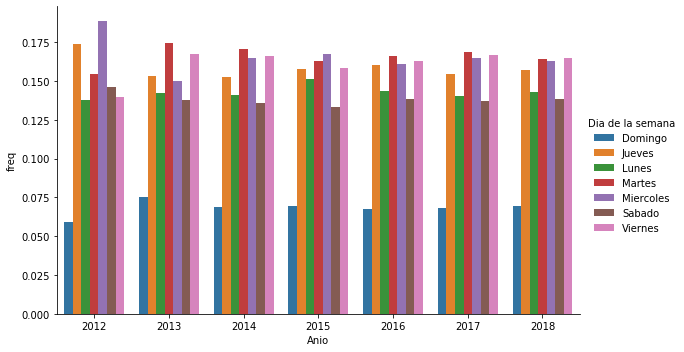

In [21]:
dfDH_DiaSemana = pd.crosstab(index=dfAccidentalidad['Anio']
                                 , columns=dfAccidentalidad['Dia de la semana']
                                 , margins=True)
dfDH_DiaSemana.columns = ["Domingo"
                          ,"Jueves"
                          ,"Lunes"
                          ,"Martes"
                          ,"Miercoles"
                          ,"Sabado"
                          ,"Viernes"
                          ,"RowTotal"]
dfDH_DiaSemana.index = ["2012","2013","2014","2015","2016","2017","2018","2019","2020","ColTotal"]
dfDH_DiaSemana2 = pd.DataFrame(dfDH_DiaSemana.T/dfDH_DiaSemana["RowTotal"]).reset_index()
dfDH_DiaSemana = pd.melt(dfDH_DiaSemana2, id_vars=['index'], var_name='Anio')
dfDH_DiaSemana = dfDH_DiaSemana[dfDH_DiaSemana['Anio']!='ColTotal']
dfDH_DiaSemana = dfDH_DiaSemana[dfDH_DiaSemana['Anio']!='2019']
dfDH_DiaSemana = dfDH_DiaSemana[dfDH_DiaSemana['Anio']!='2020']
dfDH_DiaSemana = dfDH_DiaSemana[dfDH_DiaSemana['value']!=1]
dfDH_DiaSemana.rename(columns={'index':'Dia de la semana', 'value':'freq'}, inplace=True)

ax = sns.catplot(
    x="Anio"
    , y="freq"
    , data=dfDH_DiaSemana
    , hue="Dia de la semana"
    , kind="bar"
    , aspect=10/6
)



<div style="text-align: justify">
Al discriminar la información por año, vemos que el comportamiento de cada día de la semana es similar. Es importante manifestar que, del año 2012 no se tiene la información completa, por lo que este año es el que mayor diferencia tiene a nivel de proporciones con respecto a los otros años.
</div>

* __Franja Horaria__

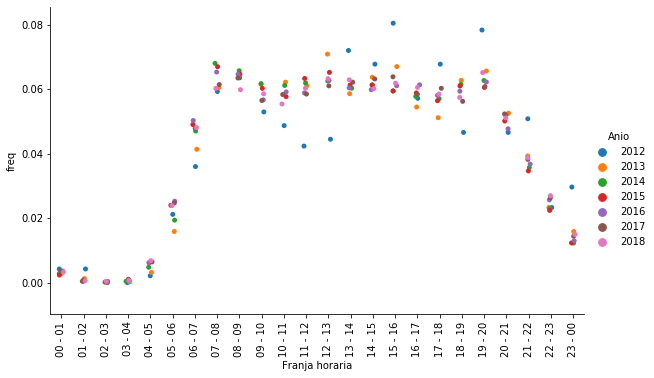

In [22]:
dfDH_FranjaHoraria = pd.crosstab(index=dfAccidentalidad['Anio']
                                 , columns=dfAccidentalidad['Franja horaria']
                                 , margins=True)
dfDH_FranjaHoraria
dfDH_FranjaHoraria.columns = ["00 - 01"
                          ,"01 - 02"
                          ,"02 - 03"
                          ,"03 - 04"
                          ,"04 - 05"
                          ,"05 - 06"
                          ,"06 - 07"
                          ,"07 - 08"
                          ,"08 - 09"
                          ,"09 - 10"
                          ,"10 - 11"
                          ,"11 - 12"
                          ,"12 - 13"
                          ,"13 - 14"
                          ,"14 - 15"
                          ,"15 - 16"
                          ,"16 - 17"
                          ,"17 - 18"
                          ,"18 - 19"
                          ,"19 - 20"
                          ,"20 - 21"
                          ,"21 - 22"
                          ,"22 - 23"
                          ,"23 - 00"
                          ,"RowTotal"]
dfDH_FranjaHoraria.index = ["2012","2013","2014","2015","2016","2017","2018","2019","2020","ColTotal"]
dfDH_FranjaHoraria2 = pd.DataFrame(dfDH_FranjaHoraria.T/dfDH_FranjaHoraria["RowTotal"]).reset_index()
dfDH_FranjaHoraria = pd.melt(dfDH_FranjaHoraria2, id_vars=['index'], var_name='Anio')
dfDH_FranjaHoraria = dfDH_FranjaHoraria[dfDH_FranjaHoraria['Anio']!='ColTotal']
dfDH_FranjaHoraria = dfDH_FranjaHoraria[dfDH_FranjaHoraria['Anio']!='2019']
dfDH_FranjaHoraria = dfDH_FranjaHoraria[dfDH_FranjaHoraria['Anio']!='2020']
dfDH_FranjaHoraria = dfDH_FranjaHoraria[dfDH_FranjaHoraria['value']!=1]
dfDH_FranjaHoraria.rename(columns={'index':'Franja horaria', 'value':'freq'}, inplace=True)

ax = sns.catplot(
    x="Franja horaria"
    , y="freq"
    , data=dfDH_FranjaHoraria
    , hue="Anio"
    , kind="strip"
    , aspect=10/6
)
ax.set_xticklabels(rotation=90)

<div style="text-align: justify">
Al discriminarlo por año, se demarca más el comportamiento de las horas pico. Para el 2018 se evidencia que la cantidad de accidentes en hora pico de la tarde aumentó.
</div>

* __Afectación__

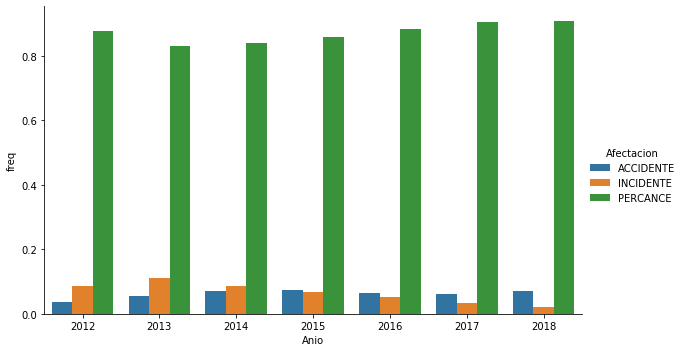

In [23]:
dfDH_Afectacion = pd.crosstab(index=dfAccidentalidad['Anio']
                                 , columns=dfAccidentalidad['Afectacion']
                                 , margins=True)
dfDH_Afectacion.columns = ["ACCIDENTE"
                           ,"INCIDENTE"
                           ,"PERCANCE"
                           ,"RowTotal"]
dfDH_Afectacion.index = ["2012","2013","2014","2015","2016","2017","2018","2019","2020","ColTotal"]
dfDH_Afectacion2 = pd.DataFrame(dfDH_Afectacion.T/dfDH_Afectacion["RowTotal"]).reset_index()
dfDH_Afectacion = pd.melt(dfDH_Afectacion2, id_vars=['index'], var_name='Anio')
dfDH_Afectacion = dfDH_Afectacion[dfDH_Afectacion['Anio']!='ColTotal']
dfDH_Afectacion = dfDH_Afectacion[dfDH_Afectacion['Anio']!='2019']
dfDH_Afectacion = dfDH_Afectacion[dfDH_Afectacion['Anio']!='2020']
dfDH_Afectacion = dfDH_Afectacion[dfDH_Afectacion['value']!=1]
dfDH_Afectacion.rename(columns={'index':'Afectacion', 'value':'freq'}, inplace=True)

ax = sns.catplot(
    x="Anio"
    , y="freq"
    , data=dfDH_Afectacion
    , hue="Afectacion"
    , kind="bar"
    , aspect=10/6
)

Al discriminarlo por año, el tipo de afectación __Percance__ siempre ha sido el predominante.

* __Gravedad del Evento__

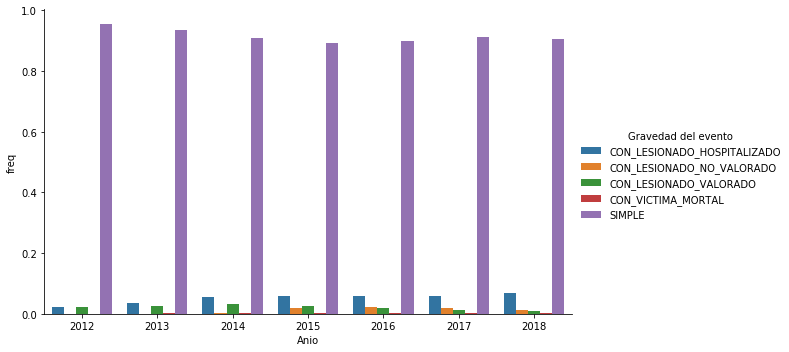

In [24]:
dfDH_Gravedad = pd.crosstab(index=dfAccidentalidad['Anio']
                                 , columns=dfAccidentalidad['Gravedad del evento']
                                 , margins=True)
dfDH_Gravedad.columns = ["CON_LESIONADO_HOSPITALIZADO"
                         ,"CON_LESIONADO_NO_VALORADO"
                         ,"CON_LESIONADO_VALORADO"
                         ,"CON_VICTIMA_MORTAL"
                         ,"SIMPLE"
                         ,"RowTotal"]
dfDH_Gravedad.index = ["2012","2013","2014","2015","2016","2017","2018","2019","2020","ColTotal"]
dfDH_Gravedad2 = pd.DataFrame(dfDH_Gravedad.T/dfDH_Gravedad["RowTotal"]).reset_index()
dfDH_Gravedad = pd.melt(dfDH_Gravedad2, id_vars=['index'], var_name='Anio')
dfDH_Gravedad = dfDH_Gravedad[dfDH_Gravedad['Anio']!='ColTotal']
dfDH_Gravedad = dfDH_Gravedad[dfDH_Gravedad['Anio']!='2019']
dfDH_Gravedad = dfDH_Gravedad[dfDH_Gravedad['Anio']!='2020']
dfDH_Gravedad = dfDH_Gravedad[dfDH_Gravedad['value']!=1]
dfDH_Gravedad.rename(columns={'index':'Gravedad del evento', 'value':'freq'}, inplace=True)

ax = sns.catplot(
    x="Anio"
    , y="freq"
    , data=dfDH_Gravedad
    , hue="Gravedad del evento"
    , kind="bar"
    , aspect=10/6
)

Al discriminarlo por año, la Gravedad de tipo __Simple__ siempre ha sido predominante.

* __Empresa Operadora__

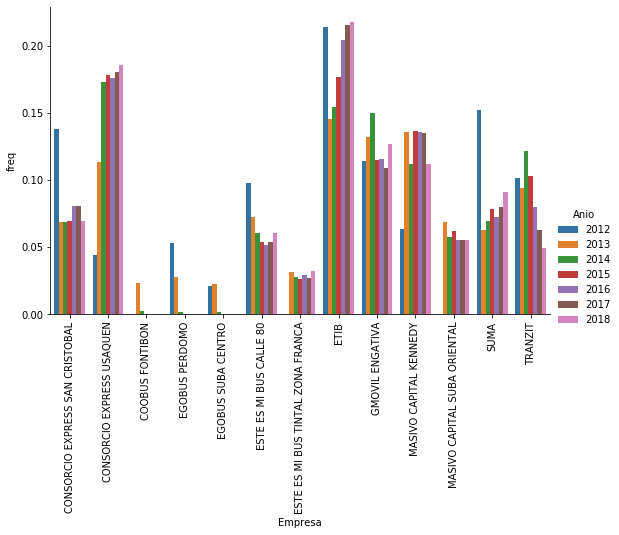

In [25]:
dfDH_Empresa = pd.crosstab(index=dfAccidentalidad['Anio']
                                 , columns=dfAccidentalidad['Empresa']
                                 , margins=True)
dfDH_Empresa.columns = ["CONSORCIO EXPRESS SAN CRISTOBAL"
                        ,"CONSORCIO EXPRESS USAQUEN"
                        ,"COOBUS FONTIBON"
                        ,"EGOBUS PERDOMO"
                        ,"EGOBUS SUBA CENTRO"
                        ,"ESTE ES MI BUS CALLE 80"
                        ,"ESTE ES MI BUS TINTAL ZONA FRANCA"
                        ,"ETIB"
                        ,"GMOVIL ENGATIVA"
                        ,"MASIVO CAPITAL KENNEDY"
                        ,"MASIVO CAPITAL SUBA ORIENTAL"
                        ,"SUMA"
                        ,"TRANZIT"
                        ,"RowTotal"]
dfDH_Empresa.index = ["2012","2013","2014","2015","2016","2017","2018","2019","2020","ColTotal"]
dfDH_Empresa2 = pd.DataFrame(dfDH_Empresa.T/dfDH_Empresa["RowTotal"]).reset_index()
dfDH_Empresa = pd.melt(dfDH_Empresa2, id_vars=['index'], var_name='Anio')
dfDH_Empresa = dfDH_Empresa[dfDH_Empresa['Anio']!='ColTotal']
dfDH_Empresa = dfDH_Empresa[dfDH_Empresa['Anio']!='2019']
dfDH_Empresa = dfDH_Empresa[dfDH_Empresa['Anio']!='2020']
dfDH_Empresa = dfDH_Empresa[dfDH_Empresa['value']!=1]
dfDH_Empresa.rename(columns={'index':'Empresa', 'value':'freq'}, inplace=True)

ax = sns.catplot(
    x="Empresa"
    , y="freq"
    , data=dfDH_Empresa
    , hue="Anio"
    , kind="bar"
    , aspect=10/6
)
ax.set_xticklabels(rotation=90)

Algunas empresas operadoras no presentan mayor accidentalidad. Aquí podemos resaltar que la empresa __ETIB__ es la que mayor accidentalidad presenta dada la información recolectada.

<br>
<div style="text-align: justify">
Partiendo de las estadísticas generadas en las gráficas anteriores, se procede a realizar BoxPlots para evidenciar el comportamiento de cada una de las variables de interés:
</div>

* __Día de la Semana__

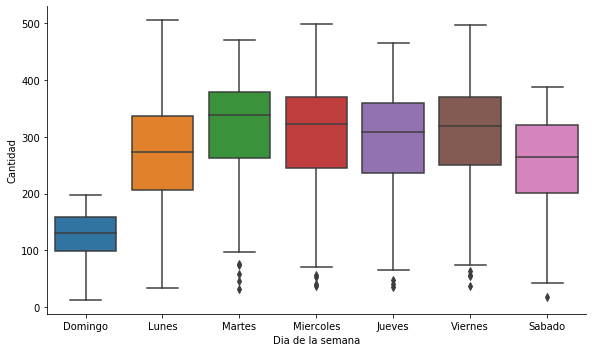

In [26]:
dfDH2_CantAnioMesDiaSemana = dfAccidentalidad[['AnioMes','Dia de la semana','Id']].groupby(['AnioMes','Dia de la semana']).count().reset_index()
dfDH2_CantAnioMesDiaSemana = dfDH2_CantAnioMesDiaSemana[dfDH2_CantAnioMesDiaSemana['AnioMes'].str[:4]!='2012']
dfDH2_CantAnioMesDiaSemana = dfDH2_CantAnioMesDiaSemana[dfDH2_CantAnioMesDiaSemana['AnioMes'].str[:4]!='2019']
dfDH2_CantAnioMesDiaSemana = dfDH2_CantAnioMesDiaSemana[dfDH2_CantAnioMesDiaSemana['AnioMes'].str[:4]!='2020']
dfDH2_CantAnioMesDiaSemana.rename(columns={'Id':'Cantidad'}, inplace=True)

ax = sns.catplot(
    x="Dia de la semana"
    , y="Cantidad"
    , data=dfDH2_CantAnioMesDiaSemana
    , kind="box"
    , aspect=10/6
    , order=['Domingo','Lunes','Martes','Miercoles','Jueves','Viernes','Sabado'])

* __Franja Horaria__

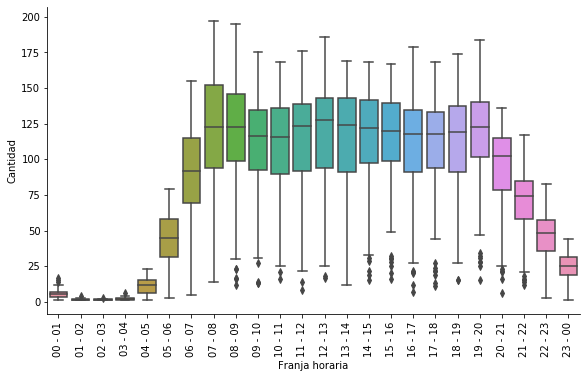

In [27]:
dfDH2_CantAnioMesFranjaHoraria = dfAccidentalidad[['AnioMes','Franja horaria','Id']].groupby(['AnioMes','Franja horaria']).count().reset_index()
dfDH2_CantAnioMesFranjaHoraria = dfDH2_CantAnioMesFranjaHoraria[dfDH2_CantAnioMesFranjaHoraria['AnioMes'].str[:4]!='2012']
dfDH2_CantAnioMesFranjaHoraria = dfDH2_CantAnioMesFranjaHoraria[dfDH2_CantAnioMesFranjaHoraria['AnioMes'].str[:4]!='2019']
dfDH2_CantAnioMesFranjaHoraria = dfDH2_CantAnioMesFranjaHoraria[dfDH2_CantAnioMesFranjaHoraria['AnioMes'].str[:4]!='2020']
dfDH2_CantAnioMesFranjaHoraria.rename(columns={'Id':'Cantidad'}, inplace=True)

ax = sns.catplot(
    x="Franja horaria"
    , y="Cantidad"
    , data=dfDH2_CantAnioMesFranjaHoraria
    , kind="box"
    , aspect=10/6
    , order=["00 - 01"
             ,"01 - 02"
             ,"02 - 03"
             ,"03 - 04"
             ,"04 - 05"
             ,"05 - 06"
             ,"06 - 07"
             ,"07 - 08"
             ,"08 - 09"
             ,"09 - 10"
             ,"10 - 11"
             ,"11 - 12"
             ,"12 - 13"
             ,"13 - 14"
             ,"14 - 15"
             ,"15 - 16"
             ,"16 - 17"
             ,"17 - 18"
             ,"18 - 19"
             ,"19 - 20"
             ,"20 - 21"
             ,"21 - 22"
             ,"22 - 23"
             ,"23 - 00"])
ax.set_xticklabels(rotation=90)

* __Afectación__

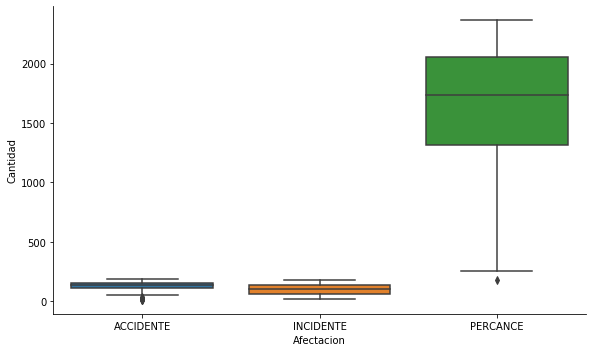

In [28]:
dfDH2_CantAnioMesAfectacion = dfAccidentalidad[['AnioMes','Afectacion','Id']].groupby(['AnioMes','Afectacion']).count().reset_index()
dfDH2_CantAnioMesAfectacion = dfDH2_CantAnioMesAfectacion[dfDH2_CantAnioMesAfectacion['AnioMes'].str[:4]!='2012']
dfDH2_CantAnioMesAfectacion = dfDH2_CantAnioMesAfectacion[dfDH2_CantAnioMesAfectacion['AnioMes'].str[:4]!='2019']
dfDH2_CantAnioMesAfectacion = dfDH2_CantAnioMesAfectacion[dfDH2_CantAnioMesAfectacion['AnioMes'].str[:4]!='2020']
dfDH2_CantAnioMesAfectacion.rename(columns={'Id':'Cantidad'}, inplace=True)

ax = sns.catplot(
    x="Afectacion"
    , y="Cantidad"
    , data=dfDH2_CantAnioMesAfectacion
    , kind="box"
    , aspect=10/6
    )

* __Gravedad del Evento__

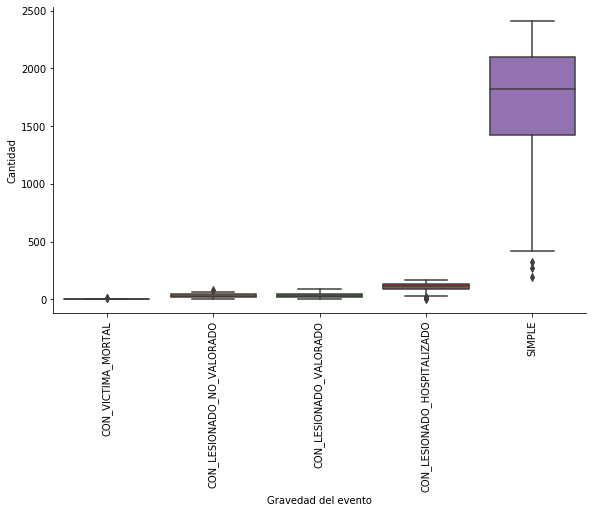

In [29]:
dfDH2_CantAnioMesGravedad = dfAccidentalidad[['AnioMes','Gravedad del evento','Id']].groupby(['AnioMes','Gravedad del evento']).count().reset_index()
dfDH2_CantAnioMesGravedad = dfDH2_CantAnioMesGravedad[dfDH2_CantAnioMesGravedad['AnioMes'].str[:4]!='2012']
dfDH2_CantAnioMesGravedad = dfDH2_CantAnioMesGravedad[dfDH2_CantAnioMesGravedad['AnioMes'].str[:4]!='2019']
dfDH2_CantAnioMesGravedad = dfDH2_CantAnioMesGravedad[dfDH2_CantAnioMesGravedad['AnioMes'].str[:4]!='2020']
dfDH2_CantAnioMesGravedad.rename(columns={'Id':'Cantidad'}, inplace=True)

ax = sns.catplot(
    x="Gravedad del evento"
    , y="Cantidad"
    , data=dfDH2_CantAnioMesGravedad
    , kind="box"
    , aspect=10/6
    , order=["CON_VICTIMA_MORTAL"
            ,"CON_LESIONADO_NO_VALORADO"
            ,"CON_LESIONADO_VALORADO"
            ,"CON_LESIONADO_HOSPITALIZADO"
            ,"SIMPLE"]
    )
ax.set_xticklabels(rotation=90)

* __Empresa Operadora__

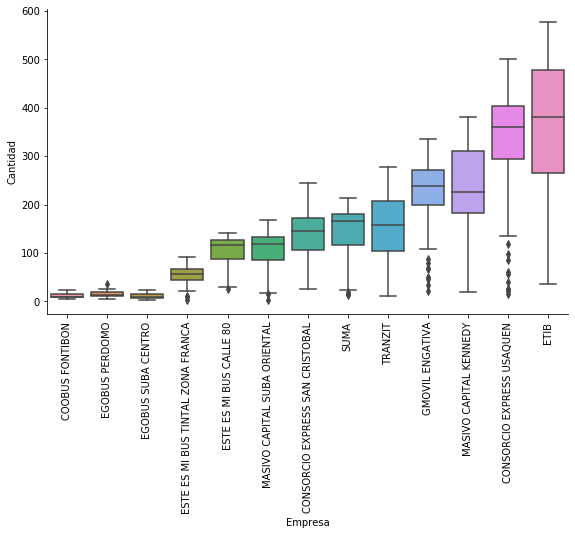

In [30]:
dfDH2_CantAnioMesEmpresa = dfAccidentalidad[['AnioMes','Empresa','Id']].groupby(['AnioMes','Empresa']).count().reset_index()
dfDH2_CantAnioMesEmpresa = dfDH2_CantAnioMesEmpresa[dfDH2_CantAnioMesEmpresa['AnioMes'].str[:4]!='2012']
dfDH2_CantAnioMesEmpresa = dfDH2_CantAnioMesEmpresa[dfDH2_CantAnioMesEmpresa['AnioMes'].str[:4]!='2019']
dfDH2_CantAnioMesEmpresa = dfDH2_CantAnioMesEmpresa[dfDH2_CantAnioMesEmpresa['AnioMes'].str[:4]!='2020']
dfDH2_CantAnioMesEmpresa.rename(columns={'Id':'Cantidad'}, inplace=True)

ax = sns.catplot(
    x="Empresa"
    , y="Cantidad"
    , data=dfDH2_CantAnioMesEmpresa
    , kind="box"
    , aspect=10/6
    , order=["COOBUS FONTIBON"
             ,"EGOBUS PERDOMO"
             ,"EGOBUS SUBA CENTRO"
             ,"ESTE ES MI BUS TINTAL ZONA FRANCA"
             ,"ESTE ES MI BUS CALLE 80"
             ,"MASIVO CAPITAL SUBA ORIENTAL"
             ,"CONSORCIO EXPRESS SAN CRISTOBAL"
             ,"SUMA"
             ,"TRANZIT"
             ,"GMOVIL ENGATIVA"
             ,"MASIVO CAPITAL KENNEDY"
             ,"CONSORCIO EXPRESS USAQUEN"
             ,"ETIB"]
    )
ax.set_xticklabels(rotation=90)

<a id='item4'></a>

### 4. Visualización Geoespacial de Datos 

Teniendo en cuenta que, la información geoespacial que tenemos es de 3 meses, procedemos a generar los mapas tanto de discriminación por localidad como el mapa de calor que muestra la conglomeración de los accidentes.

<a id='item4_1'></a>

#### 4.1. Mapa de Accidentalidad por Localidad

In [31]:
#Importamos el archivo de geolocalización en JSON
localidad_geo = r'../geojson/localidades.json'

#Unificamos nuestro DF de Localidades con el DF principal (De solo coordenadas)
dfAccCoordLocalidad = pd.merge(left=dfAccCoord, right=dfUnificadoLocalidades, how='left', left_on=['Lon','Lat'], right_on=['Longitud','Latitud'])
dfAccCoordLocalidad

#Creamos un nuevo DF de Registros con Localidades para la visualización.
dfSoloLocalidades = dfAccCoordLocalidad[dfAccCoordLocalidad['LocalidadFinal'].notna()]

dfAgrupadoLocalidades = dfSoloLocalidades[['LocalidadFinal','NumAccidentes']].groupby('LocalidadFinal').sum().reset_index()

#Definimos la Latitud y Longitud de Bogotá para que sea el punto inicial de la visualización
latitude=4.715295000000026
longitude=-74.03390915799997

mapAccidentesLocalidad = folium.Map(location=[latitude, longitude], zoom_start=11)
mapAccidentesLocalidad.choropleth(
    geo_data=localidad_geo
    , name='choropleth'
    , data=dfAgrupadoLocalidades
    , columns=['LocalidadFinal','NumAccidentes']
    , key_on='feature.properties.name'
    , fill_color = 'YlOrBr'
    , fill_opacity = 0.9
    , line_opacity = 0.5
    , legend_name = 'Cantidad Accidentes'
    , reset=True
)
mapAccidentesLocalidad

In [32]:
mapAccidentesLocalidad.save(r'../resultViews/AccidentesPorLocalidadTrimestre.html')

De acuerdo a la información desplegada, se detecta que las localidades __Kennedy__ y __Engativá__ son las que mayor accidentes presentan.

<a id='item4_2'></a>

#### 4.2. Mapa de Calor por Conglomeración de Accidentes

In [33]:
def generateBaseMap(default_location=[latitude, longitude], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [34]:
heatMapAccidentesLocalidad = generateBaseMap()
HeatMap(data=dfSoloLocalidades[['Latitud', 'Longitud', 'NumAccidentes']].groupby(['Latitud', 'Longitud']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(heatMapAccidentesLocalidad)
heatMapAccidentesLocalidad

In [35]:
heatMapAccidentesLocalidad.save(r'../resultViews/HeatMapAccidentalidad.html')

Entre más rojo se vea en el mapa, más acidentes conglomerados en la zona habrá. Visualmente podríamos detectar que se podrían definir alrededor de 4 clústers de accidentes en toda Bogotá.

<a id='item5'></a>

### 5. Bootstrapping e Intervalos de Confianza

<div style="text-align: justify">Para utilizar el método de Bootstraping, decidimos agrupar la cantidad de accidentes por día y ver la distribución de la información. Con esto podemos identificar en promedio, cuántos accidentes por día se están registrando sin importar su gravedad, el actor vial, ni la localidad del accidente. </div>

In [36]:
#Definimos nuestro DataFrame por día y día de la semana
dfAccPorDia = dfAccidentalidad[['Dia','Dia de la semana']]
dfAccPorDia.insert(2,'NumAccidentes',1)

#Creamos el DataFrame que se usará como base para la implementación de Bootstraping
dfBootAccPorDia = dfAccPorDia.groupby(['Dia','Dia de la semana']).sum().reset_index()

#Sacamos nuestra población total:
poblacion = dfBootAccPorDia['NumAccidentes'].values

#Sacamos una muestra aleatoria de 400 datos:
muestra = np.random.choice(poblacion, size=400)

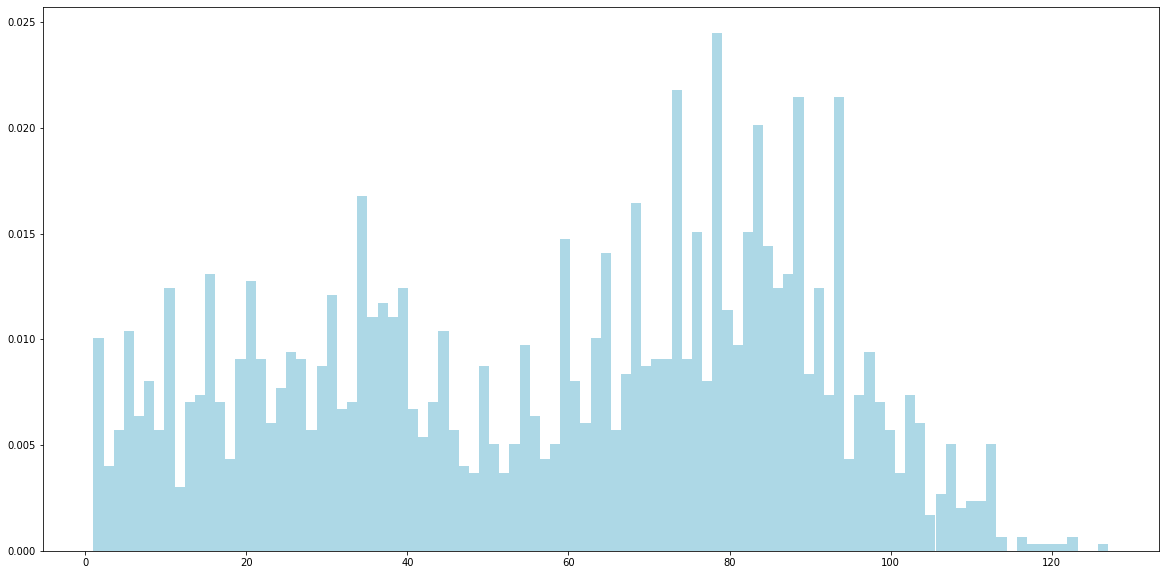

In [37]:
# Creamos un histograma para ver el comportamiento de la población total
plt.figure(figsize=(20,10))
plt.hist(poblacion, 100, density=True, color='lightblue')
plt.show()

<div style="text-align: justify">
Como se puede evidenciar con el histograma, no tenemos una distribución definida de la información. Ahora, con el fin de implementar el método Bootstrap, con la muestra de 400 datos generados anteriormente, vamos a remuestrear con reemplazo para sacar nuestra nueva distribución y elegir así los intervalos de confianza
</div>

In [38]:
#Utilizamos la metodología bootstrap basado en nuestra muestra para conocer el xbarra
promedio_muestra = []
for _ in range(100000): #100.000 repeticiones
    muestra_n = np.random.choice(muestra, size=400)
    promedio_muestra.append(muestra_n.mean())
print("El promedio de la población es de: ", poblacion.mean())
print("El promedio de la muestra es de: ", muestra.mean())
print("El promedio luego del bootstrap es de: ", np.mean(promedio_muestra))

El promedio de la población es de:  58.00380228136882
El promedio de la muestra es de:  57.1025
El promedio luego del bootstrap es de:  57.101855575


In [39]:
#Definimos nuestras variables para identificar los intervalos de confianza
confidence = 0.95
mu = np.mean(promedio_muestra)
sigma = np.std(promedio_muestra)
n = len(promedio_muestra)
h = sigma * t.ppf((1+confidence) / 2, n-1)
IC_inferior =  mu - h
IC_superior = mu + h
print("El límite Inferior con una confianza del 95% es: ", IC_inferior)
print("El límite Superior con una confianza del 95% es: ", IC_superior)

El límite Inferior con una confianza del 95% es:  54.07397583069859
El límite Superior con una confianza del 95% es:  60.12973531930141


Habiendo encontrado nuestros intervalos de confianza, procedemos a graficar de nuevo el histograma de nuestro __xbarra__ y los intervalos con el 95% de confianza

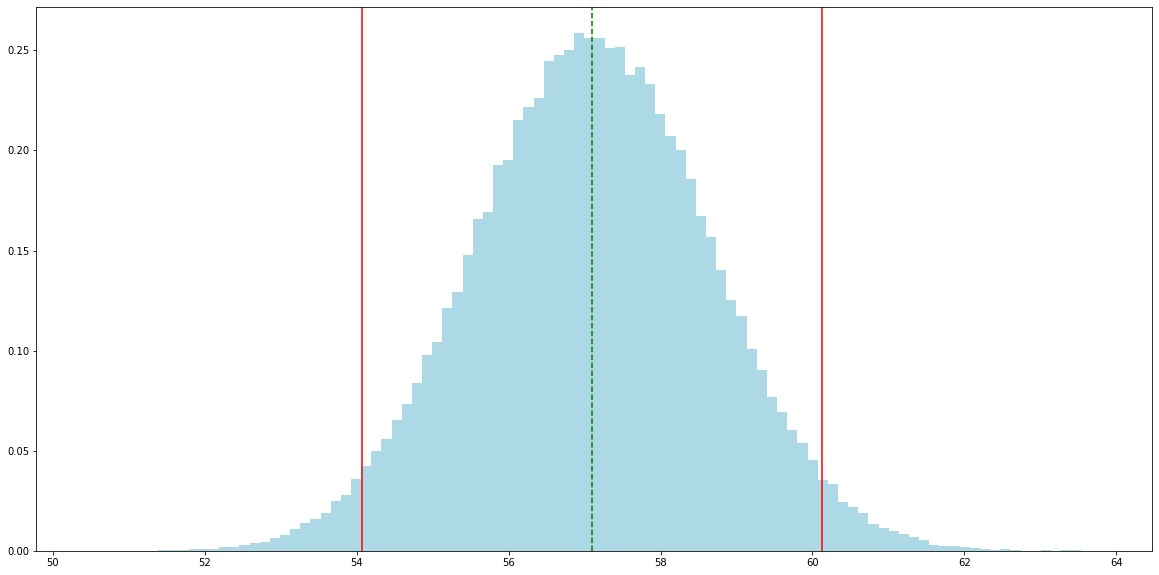

In [40]:
#Imprimimos nuestro histográma con los intervalos de confianza
plt.figure(figsize=(20,10))
plt.hist(promedio_muestra, 100, density=True, color='lightblue')
plt.axvline(x=mu, color='green', linestyle='--')
plt.axvline(x=IC_inferior , color='red')
plt.axvline(x=IC_superior , color='red')
plt.show()

In [41]:
md("Con lo anterior, podemos definir que, diariamente se pueden presentar entre __{}__ y __{}__ accidentes en la que se involucre un vehículo del SITP".format(math.floor(IC_inferior),math.floor(IC_superior)))

Con lo anterior, podemos definir que, diariamente se pueden presentar entre __54__ y __60__ accidentes en la que se involucre un vehículo del SITP

<a id='item6'></a>

### 6. Modelado

Se abarcaron 2 modelos con la información recibida. Uno para realizar la clusterización de las Localidades basado en los parámetros de interés y otro para clasificar cuando un accidente genera inmovilización al vehículo.

<a id='item6_1'></a>

#### 6.1. Clusterización de Localidades

<div style="text-align: justify">
Primero, definimos los parámetros de interés (De acuerdo a la completitud de las variables). Eliminamos los registros vacíos y transponemos cada característica en columnas con valores booleanos para identificar cada registro si tiene o no esa característica en el accidente.
</div>    

In [42]:
dfClusterLocalidades = dfSoloLocalidades[['LocalidadFinal','Gravedad del evento','Tipo','Dia de la semana','Franja horaria','Afectacion']]
dfClusterLocalidades = dfClusterLocalidades[dfClusterLocalidades['Gravedad del evento'].notna()]
dfClusterLocalidades = dfClusterLocalidades[dfClusterLocalidades['Tipo'].notna()]
dfClusterLocalidades = dfClusterLocalidades[dfClusterLocalidades['Dia de la semana'].notna()]
dfClusterLocalidades = dfClusterLocalidades[dfClusterLocalidades['Franja horaria'].notna()]
dfClusterLocalidades = dfClusterLocalidades[dfClusterLocalidades['Afectacion'].notna()]

dfCluster_OneHot = pd.get_dummies(dfClusterLocalidades[['Gravedad del evento','Tipo','Dia de la semana','Franja horaria','Afectacion']], prefix="", prefix_sep="")
dfCluster_OneHot['LocalidadFinal'] = dfClusterLocalidades['LocalidadFinal']
fixed_columns = [dfCluster_OneHot.columns[-1]] + list(dfCluster_OneHot.columns[:-1])
dfCluster_OneHot = dfCluster_OneHot[fixed_columns]

Definimos una función que nos retorne las características más comunes por localidad partiendo de las características definidas anteriormente

In [43]:
def return_most_common_type(row, num_top_type):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_type]

Identificamos, cuál es el `K` que mejor se adecúa para definir clústeres y con base en eso ejecutamos nuestro modelo 

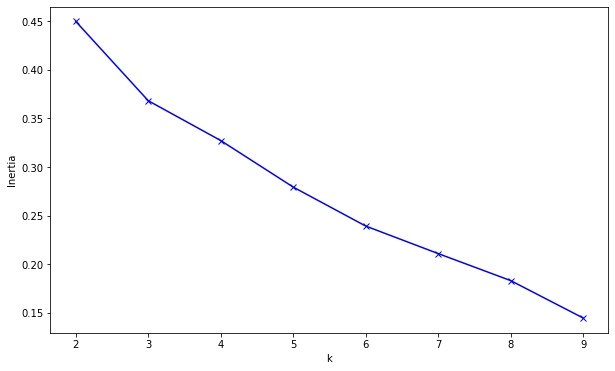

In [44]:
dfClusterByLocalidad  = dfCluster_OneHot.groupby('LocalidadFinal').mean().reset_index()
dfClusterizado = dfClusterByLocalidad.drop('LocalidadFinal', 1)
#Inercia o distancia intra-cluster
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(init="k-means++", n_clusters=k, random_state=0, n_init=12)
    km = km.fit(dfClusterizado)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure(figsize=(10,6))    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

<div style="text-align: justify">Adicionalmente, utilizamos el coeficiente de siluetas para sustentar nuestra decisión de K. El cobjetivo del coeficiente de silueta es identificar cuál es el número óptimo de agrupamientos. Un valor más alto de este índice indica un caso más deseable del número de clúster</div>

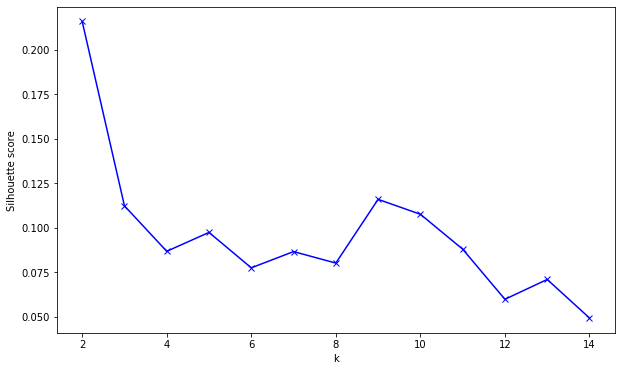

In [45]:
#Coeficiente de silueta
silhouette_scores = []
K = range(2,15)
for k in K:
    km = KMeans(init="k-means++", n_clusters=k, random_state=0, n_init=12)
    km = km.fit(dfClusterizado)
    y = km.predict(dfClusterizado)
    silhouette_scores.append(silhouette_score(dfClusterizado, y))
plt.figure(figsize=(10,6))   
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

<div style="text-align: justify">
Dado que, la inercia intra-cluster no está del todo definida y además el coeficiente de silueta nos denota que la cantidad de clústeres más acertado serían 3 o 9 clústeres, definimos arbitrariamente nuestro modelo con una cantidad de clúster igual a 3, dejando como aletaorios los centroides y con una iteración de 12.
<br>
<br>
Posteriormente, con nuestra función de retornar las características más comunes, le indicamos que sean máximo 10 características y por último vemos nuestras localidades con el clúster identificado
</div>

In [46]:
# Asignamos la cantidad de clusters a utilizar
kclusters = 3
# Corremos el algoritmo k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, random_state=0, n_init=12).fit(dfClusterizado)
# Definimos la cantidad de características que queremos ver
num_top = 10

indicators = ['era', 'da', 'era', 'ta', 'ta', 'ta', 'ma', 'va', 'na', 'ma']

columns = ['LocalidadFinal']
for ind in np.arange(num_top):
    try:
        columns.append('{}{} Característica más común'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}to  Característica más común'.format(ind+1))

dfLocalidadClusterizada = pd.DataFrame(columns=columns)
dfLocalidadClusterizada['LocalidadFinal'] = dfClusterByLocalidad['LocalidadFinal']

for ind in np.arange(dfClusterByLocalidad.shape[0]):
    dfLocalidadClusterizada.iloc[ind, 1:] = return_most_common_type(dfClusterByLocalidad.iloc[ind, :], num_top)

dfLocalidadClusterizada.insert(0, 'Cluster Labels', kmeans.labels_)
dfLocalidadClusterizada.sort_values(by=['Cluster Labels'])

Cluster Labels                LocalidadFinal  \
0                0      LOCALIDAD ANTONIO NARINO   
15               0         LOCALIDAD TEUSAQUILLO   
14               0                LOCALIDAD SUBA   
10               0       LOCALIDAD PUENTE ARANDA   
17               0             LOCALIDAD USAQUEN   
7                0            LOCALIDAD FONTIBON   
9                0        LOCALIDAD LOS MARTIRES   
1                0      LOCALIDAD BARRIOS UNIDOS   
3                1          LOCALIDAD CANDELARIA   
5                2      LOCALIDAD CIUDAD BOLIVAR   
8                2             LOCALIDAD KENNEDY   
4                2           LOCALIDAD CHAPINERO   
11               2  LOCALIDAD RAFAEL URIBE URIBE   
12               2       LOCALIDAD SAN CRISTOBAL   
13               2            LOCALIDAD SANTA FE   
2                2                LOCALIDAD BOSA   
16               2          LOCALIDAD TUNJUELITO   
6                2            LOCALIDAD ENGATIVA   
18               2                LOCALIDAD USME   

   1era Característica más común 2da Característica más común  \
0                       PERCANCE                       SIMPLE   
15                      PERCANCE                       SIMPLE   
14                        SIMPLE                     PERCANCE   
10                      PERCANCE                       SIMPLE   
17                      PERCANCE                       SIMPLE   
7                       PERCANCE                       SIMPLE   
9                         SIMPLE                     PERCANCE   
1                       PERCANCE                       SIMPLE   
3                       PERCANCE                       SIMPLE   
5                         SIMPLE                     PERCANCE   
8                       PERCANCE                       SIMPLE   
4                       PERCANCE                       SIMPLE   
11                      PERCANCE                       SIMPLE   
12                      PERCANCE                       SIMPLE   
13                      PERCANCE                       SIMPLE   
2                       PERCANCE                       SIMPLE   
16                      PERCANCE                       SIMPLE   
6                         SIMPLE                     PERCANCE   
18                      PERCANCE                       SIMPLE   

   3era Característica más común 4ta Característica más común  \
0                 CON_PARTICULAR                      Viernes   
15                CON_PARTICULAR                      Viernes   
14                CON_PARTICULAR                       Martes   
10                CON_PARTICULAR                      Viernes   
17                CON_PARTICULAR                      Viernes   
7                 CON_PARTICULAR                      Viernes   
9                 CON_PARTICULAR                      Viernes   
1                 CON_PARTICULAR                    Miercoles   
3                 CON_PARTICULAR                    Miercoles   
5                 CON_PARTICULAR                       Martes   
8                 CON_PARTICULAR                       Martes   
4                 CON_PARTICULAR                      Viernes   
11                CON_PARTICULAR                       Martes   
12                CON_PARTICULAR                       Sabado   
13                CON_PARTICULAR                       Jueves   
2                 CON_PARTICULAR                      Viernes   
16                CON_PARTICULAR                        Lunes   
6                 CON_PARTICULAR                       Martes   
18                CON_PARTICULAR                      Domingo   

   5ta Característica más común 6ta Característica más común  \
0                        Sabado                       Martes   
15                        Lunes                       Martes   
14                       Sabado                      Viernes   
10                       Jueves                        Lunes   
17                       Martes          

Dadas las 10 características más comunes de cada uno de los Clústers se logra apreciar que en todas las localidades los eventos que mayor se presencian son de afectación __Percance__, gravedad __Simple__ y actor vial involucrado __Particular__. 

El __clúster 0__ comprende 8 localidades que son:
* LOCALIDAD ANTONIO NARIÑO
* LOCALIDAD BARRIOS UNIDOS
* LOCALIDAD FONTIBÓN
* LOCALIDAD LOS MÁRTIRES
* LOCALIDAD PUENTE ARANDA
* LOCALIDAD SUBA
* LOCALIDAD TEUSAQUILLO
* LOCALIDAD USAQUÉN

Los días que mayor accidentalidad se presenta son los __viernes__ y __martes__.

El __clúster 1__ comprende solo la __LOCALIDAD CANDELARIA__ y los días que mayor accidentalidad presenta son los __miércoles__ y los __lunes__. Adicionalmente la Franja Horaria donde mayor accidentalidad se presenta es de 10 a 11 de la mañana.

El __clúster 2__ comprende 10 localidades que son:
* LOCALIDAD BOSA
* LOCALIDAD CHAPINERO
* LOCALIDAD CIUDAD BOLIVAR
* LOCALIDAD ENGATIVA
* LOCALIDAD KENNEDY
* LOCALIDAD RAFAEL URIBE URIBE
* LOCALIDAD SAN CRISTOBAL
* LOCALIDAD SANTA FÉ
* LOCALIDAD TUNJUELITO
* LOCALIDAD USME

Los días que mayor accidentalidad se presenta son los __viernes__, __martes__ y __lunes__, sin embargo, lo que lo diferencia con el clúster 0 es el actor vial involucrado. Para este clúster los accidentes con otros vehículos de servicio público tienen mayor presencia

Visualmente, se puede identificar las localidades agrupadas por sus clúster de acuerdo al color:
* __<span style="color:orange;">Clúster 0</span>__ 
* __<span style="background-color:yellow;">Clúster 1</span>__ 
* __<span style="color:blue;">Clúster 2</span>__ 


In [47]:
mapClusterLocalidad = folium.Map(location=[latitude, longitude], zoom_start=11)
mapClusterLocalidad.choropleth(
    geo_data=localidad_geo
    , name='choropleth'
    , data=dfLocalidadClusterizada
    , columns=['LocalidadFinal','Cluster Labels']
    , key_on='feature.properties.name'
    , fill_color = 'Spectral'
    , fill_opacity = 0.9
    , line_opacity = 0.5
    , legend_name = 'Id de Cluster'
    , reset=True
)
mapClusterLocalidad

In [48]:
mapClusterLocalidad.save(r'../resultViews/ClusterLocalidadesMap.html')

<a id='item6_2'></a>

#### 6.2. Árbol de Decisión de Inmovilización

Basado en la columna __Inmovilizado__ que nos indica si el accidente generó inmovilización del vehículo del Sistema Integrado de Transporte Público, definimos un árbol de decisión el cual nos permitirá identificar, si con los parámetros de interés, se puede clasificar los accidentes que generan inmovilización. 

Vemos que, del total de datos solo 1.885 accidentes generaron inmovilización, lo cual corresponde al __1.3%__ del total de accidentes de la base.

In [49]:
dfAccidentalidad[['Inmovilizado','Id']].groupby('Inmovilizado').count().reset_index()

Inmovilizado      Id
0           NO  135410
1           SI    1885

Creamos un DataFrame que nos permita tener la información requerida para el árbol de decisión

In [50]:
dfDecisionTree = dfAccidentalidad[['Dia de la semana','Franja horaria','Afectacion','Gravedad del evento','Empresa','Tipo','Inmovilizado']]
dfDecisionTree = dfDecisionTree[dfDecisionTree['Gravedad del evento'].notna()]
dfDecisionTree = dfDecisionTree[dfDecisionTree['Tipo'].notna()]
dfDecisionTree = dfDecisionTree[dfDecisionTree['Dia de la semana'].notna()]
dfDecisionTree = dfDecisionTree[dfDecisionTree['Franja horaria'].notna()]
dfDecisionTree = dfDecisionTree[dfDecisionTree['Afectacion'].notna()]

Preprocesamos los datos para que cada categoría de las variables independientes tengan un valor numérico

In [51]:
#Definimos la variable objetivo o dependiente
varDependiente = dfDecisionTree["Inmovilizado"]

#Definimos las variables a usar en el árbol de Decisión:
varIndependientes = dfDecisionTree[['Dia de la semana','Franja horaria','Afectacion','Gravedad del evento','Empresa','Tipo']].values

#Preprocesamos los datos definiéndoles un id por valor

le_DiaSemana = preprocessing.LabelEncoder()
le_DiaSemana.fit(['Domingo'
                  ,'Lunes'
                  ,'Martes'
                  ,'Miercoles'
                  ,'Jueves'
                  ,'Viernes'
                  ,'Sabado'])
varIndependientes[:,0] = le_DiaSemana.transform(varIndependientes[:,0]) 

le_FranjaHoraria = preprocessing.LabelEncoder()
le_FranjaHoraria.fit(["00 - 01"
             ,"01 - 02"
             ,"02 - 03"
             ,"03 - 04"
             ,"04 - 05"
             ,"05 - 06"
             ,"06 - 07"
             ,"07 - 08"
             ,"08 - 09"
             ,"09 - 10"
             ,"10 - 11"
             ,"11 - 12"
             ,"12 - 13"
             ,"13 - 14"
             ,"14 - 15"
             ,"15 - 16"
             ,"16 - 17"
             ,"17 - 18"
             ,"18 - 19"
             ,"19 - 20"
             ,"20 - 21"
             ,"21 - 22"
             ,"22 - 23"
             ,"23 - 00"])
varIndependientes[:,1] = le_FranjaHoraria.transform(varIndependientes[:,1])

le_Afectacion = preprocessing.LabelEncoder()
le_Afectacion.fit(['ACCIDENTE'
                   ,'INCIDENTE'
                   ,'PERCANCE'])
varIndependientes[:,2] = le_Afectacion.transform(varIndependientes[:,2]) 

le_Gravedad = preprocessing.LabelEncoder()
le_Gravedad.fit(["CON_VICTIMA_MORTAL"
            ,"CON_LESIONADO_NO_VALORADO"
            ,"CON_LESIONADO_VALORADO"
            ,"CON_LESIONADO_HOSPITALIZADO"
            ,"SIMPLE"])
varIndependientes[:,3] = le_Gravedad.transform(varIndependientes[:,3]) 

le_Empresa = preprocessing.LabelEncoder()
le_Empresa.fit(["COOBUS FONTIBON"
             ,"EGOBUS PERDOMO"
             ,"EGOBUS SUBA CENTRO"
             ,"ESTE ES MI BUS TINTAL ZONA FRANCA"
             ,"ESTE ES MI BUS CALLE 80"
             ,"MASIVO CAPITAL SUBA ORIENTAL"
             ,"CONSORCIO EXPRESS SAN CRISTOBAL"
             ,"SUMA"
             ,"TRANZIT"
             ,"GMOVIL ENGATIVA"
             ,"MASIVO CAPITAL KENNEDY"
             ,"CONSORCIO EXPRESS USAQUEN"
             ,"ETIB"])
varIndependientes[:,4] = le_Empresa.transform(varIndependientes[:,4]) 

le_ActorVial = preprocessing.LabelEncoder()
le_ActorVial.fit(["APRISIONAMIENTO_CON_PUERTAS"
                ,"CAIDA_DENTRO_DEL_MOVIL"
                ,"CAIDA_DESDE_EL_MOVIL"
                ,"COLISION_MULTIPLE"
                ,"CON_ANIMAL"
                ,"CON_BICICLETA"
                ,"CON_BICITAXI"
                ,"CON_BUS_BRT_(TRONCAL-ALIMENTADOR)"
                ,"CON_BUS_ZONAL"
                ,"CON_COMPONENTE_CARROCERIA_INTERNA"
                ,"CON_INFRAESTRUCTURA"
                ,"CON_MOTO"
                ,"CON_PARTICULAR"
                ,"CON_PEATON"
                ,"CON_SERVICIO_PUBLICO_COLECTIVO"
                ,"CON_SERVICIO_PUBLICO_ESPECIAL"
                ,"CON_SERVICIO_PUBLICO_INDIVIDUAL-TAXI"
                ,"CON_VEHICULO_DE_EMERGENCIA"
                ,"CON_VEHICULO_DE_TRACCION_ANIMAL_O_HUMANA"
                ,"EN_ASCENSO_AL_BUS","VOLCAMIENTO"])
varIndependientes[:,5] = le_ActorVial.transform(varIndependientes[:,5])

Particionamos los datos para entrenar el modelo y posteriormente probarlo de acuerdo a las reglas que genere

In [52]:
#Particionamos los datos en 70/30 para entrenamiento/prueba del modelo:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(varIndependientes
                                                                , varDependiente
                                                                , test_size=0.3
                                                                , random_state=48
                                                                , stratify=varDependiente)
print ('Set de datos de Entrenamiento:', X_trainset.shape,  y_trainset.shape)
print ('Set de datos de prueba:', X_testset.shape,  y_testset.shape)

Set de datos de Entrenamiento: (94122, 6) (94122,)
Set de datos de prueba: (40338, 6) (40338,)


Creamos una lista desde 2 hasta 50 valores de Profundidad para evaluar cuál es la profundidad óptima para nuestro modelo

In [53]:
#se crea una lista para determinar la profundidad máxima de cada árbol
max_depth_values = range(2,50)

train_error = []
generalization_error = []

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', criterion="entropy")
    decision_tree.fit(X_trainset, y_trainset)
    train_error.append(1 - decision_tree.score(X_trainset, y_trainset))
    generalization_error.append(1 - decision_tree.score(X_testset, y_testset))
    

Agregamos a un DataFrame el error tanto de entrenamiento como de Prueba para elegir el que tenga menor error

In [54]:
#crea data frames de error train y test
df_error_train = pd.DataFrame(train_error, columns= ['Error_train'], index=max_depth_values)
df_error_test = pd.DataFrame(generalization_error, columns= ['Error_test'], index=max_depth_values)
#concatena los data frame error train y test
df_error = pd.concat([df_error_train,df_error_test],axis=1 )
#selecciona el error mas bajo en test
df_error['error_dif'] = df_error['Error_test'] - df_error['Error_train']
df_error[df_error['error_dif'] == df_error['error_dif'].min()]

Error_train  Error_test  error_dif
6     0.063163    0.063885   0.000722

Identificamos que nuestro punto de balance entre los errores es definiendo 6 capas de profundidad a nuestro árbol

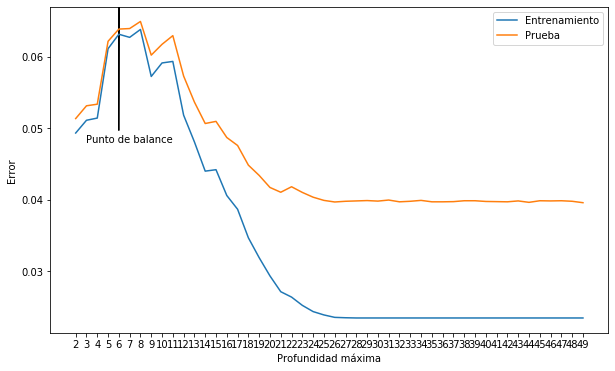

In [55]:
plt.figure(figsize = (10, 6))

plt.plot(max_depth_values, train_error, label="Entrenamiento")
plt.plot(max_depth_values, generalization_error, label="Prueba")
plt.xticks(max_depth_values)
plt.xlabel("Profundidad máxima")
plt.ylabel("Error")
plt.arrow(6, 0.05, 0.05, 0.06, head_length=0.02, fc='k', ec='k')
plt.text(3, 0.048, 'Punto de balance')
plt.legend();

Definimos el modelo de clasificación mediante un árbol de decisión definiéndole como máximo 6 niveles y lo entrenamos con nuestros datos particionados (70%)

In [56]:
#Definimos el modelo con un máximo de 30 niveles
arbolInmovilizacion = DecisionTreeClassifier(criterion="entropy", max_depth = 6)

#Entrenamos el modelo con nuestro set de entrenamiento
arbolInmovilizacion.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Luego de haber entrenado el modelo, lo probamos con el 30% de los datos y medimos la fiabilidad del árbol

In [57]:
#Probamos nuestro árbol con el set de prueba:
prediccionInmovilizacion = arbolInmovilizacion.predict(X_testset)
#Medimos la seguridad de nuestro modelo de acuerdo al set de pruebas:
print("Fiabilidad del ábol de decisión: ", metrics.accuracy_score(y_testset, prediccionInmovilizacion))

Fiabilidad del ábol de decisión:  0.9858198224998761


Visualmente podemos observar las variables utilizadas dentro de los 6 niveles seleccionados

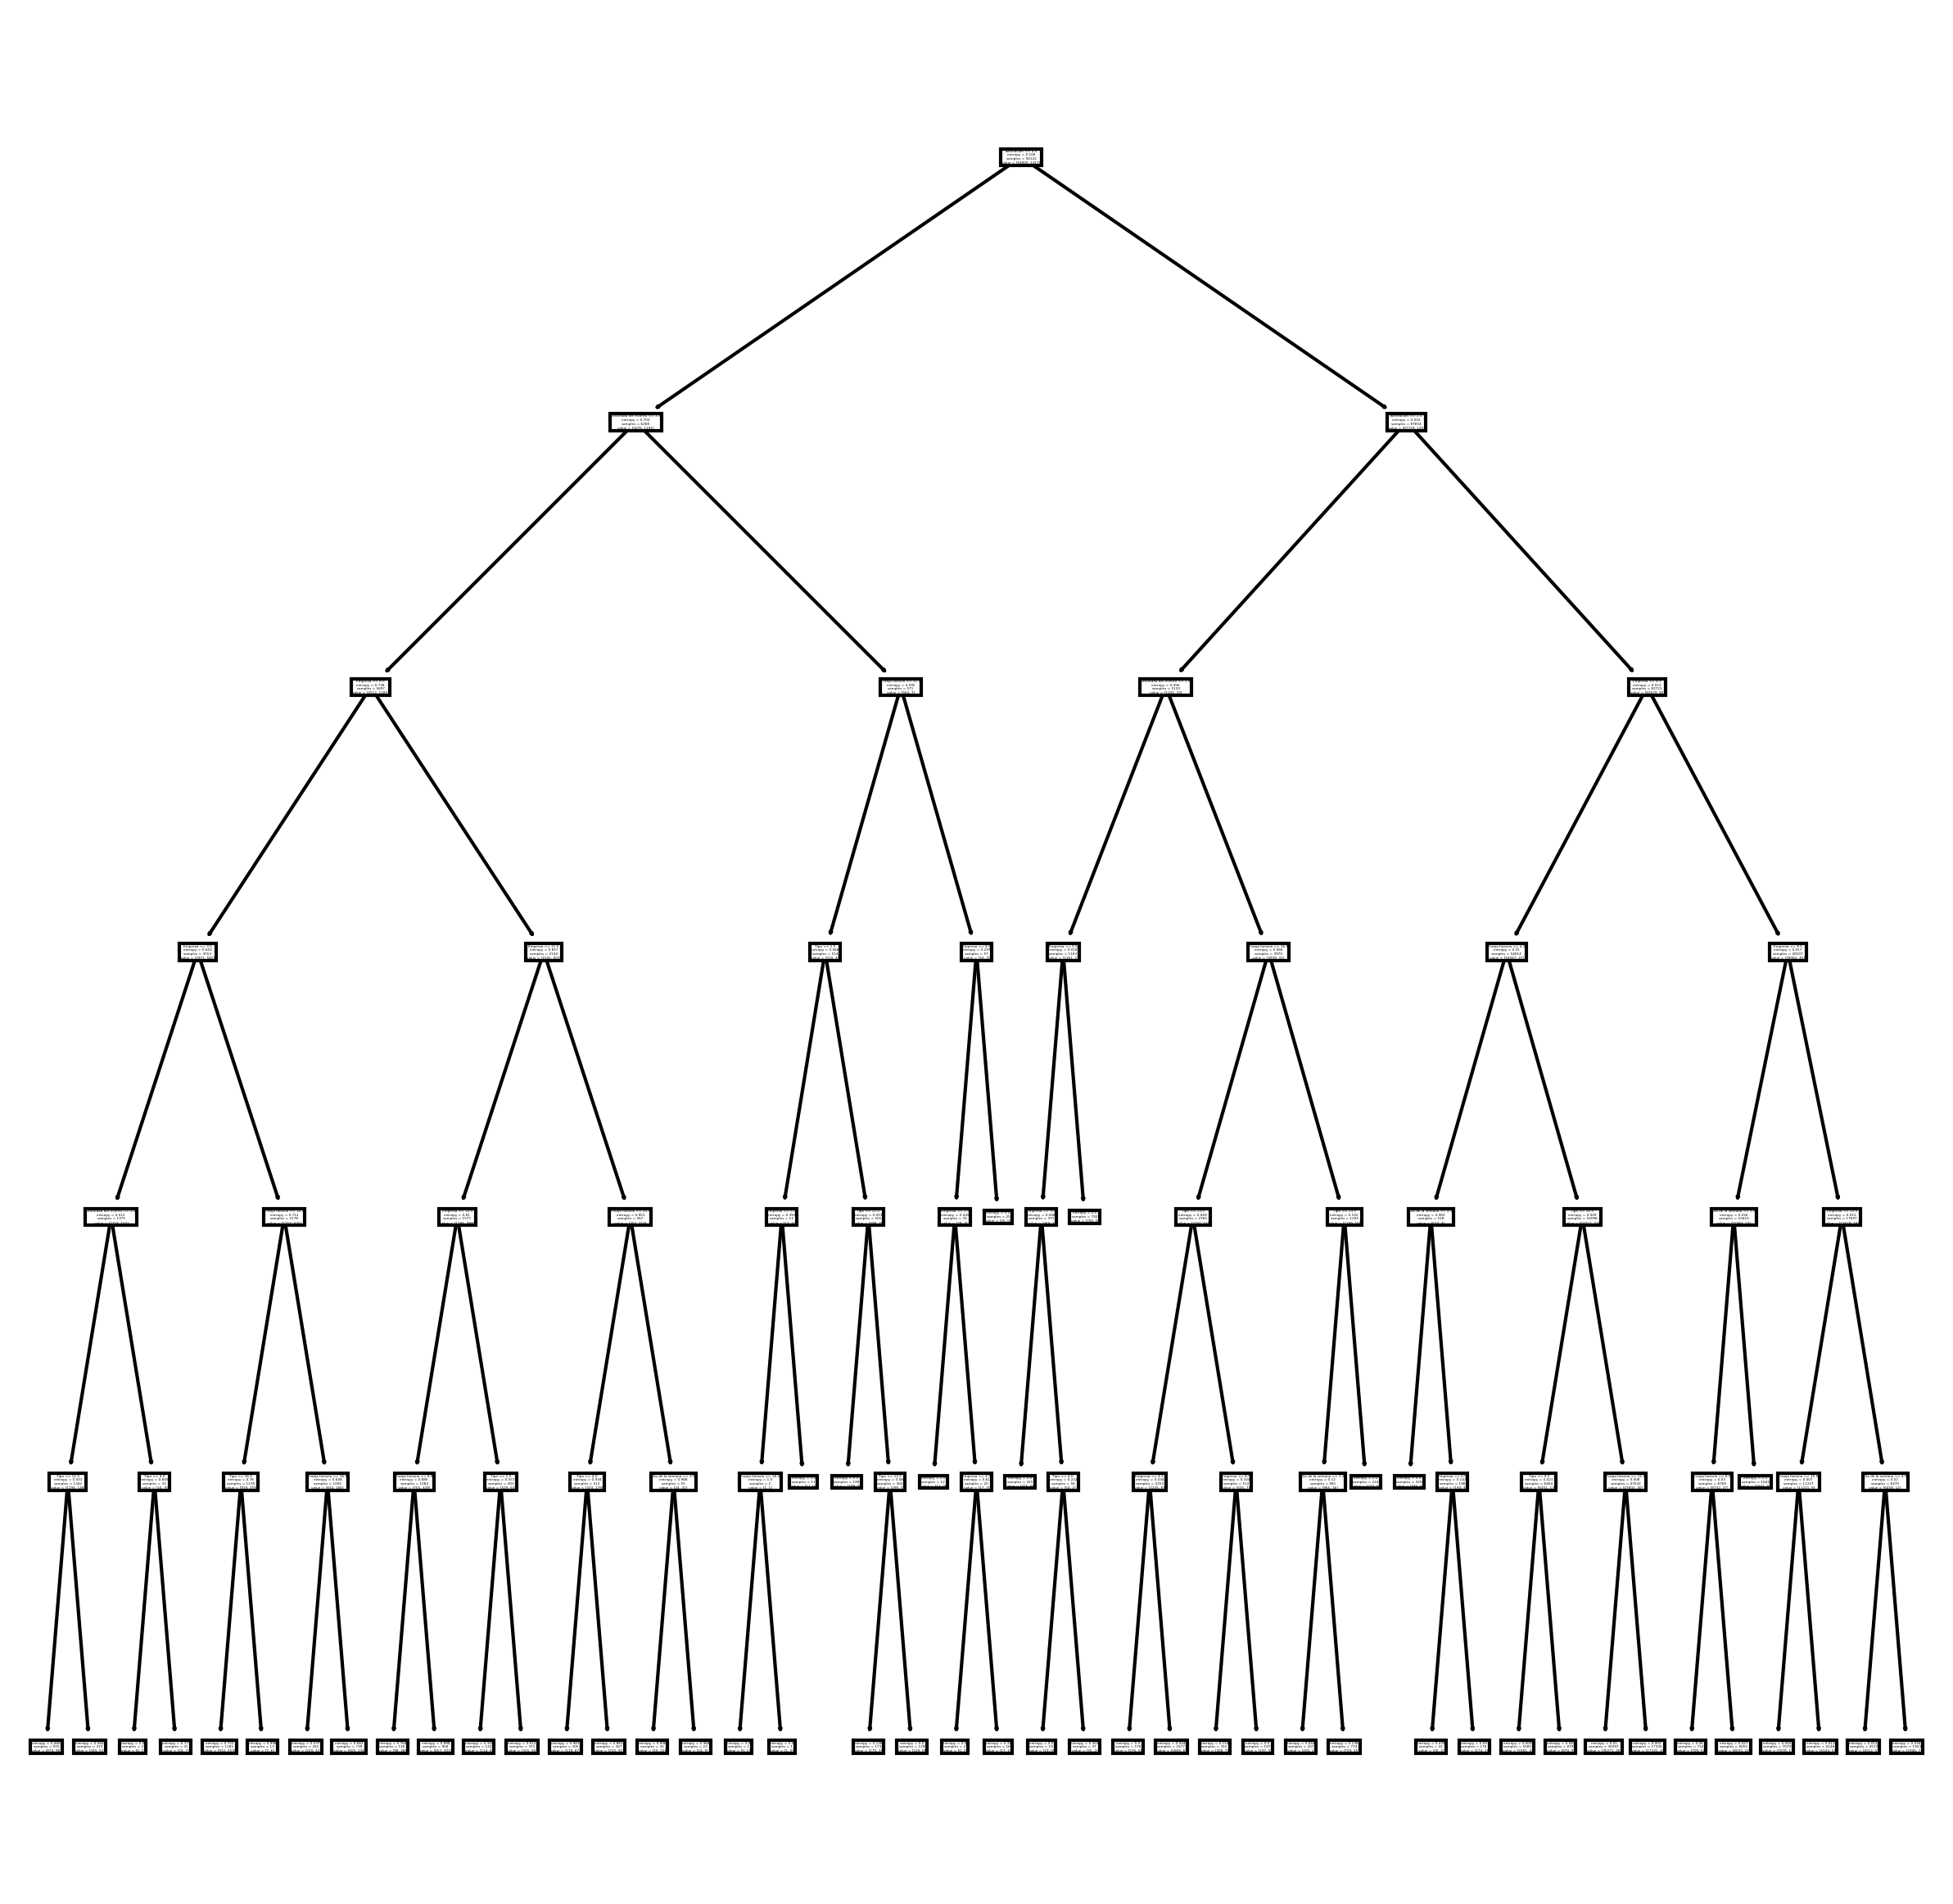

In [58]:
fn=['Dia de la semana','Franja horaria','Afectacion','Gravedad del evento','Empresa','Tipo']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (10,10), dpi=300)
tree.plot_tree(arbolInmovilizacion
               , feature_names = fn
               )
fig.savefig('../resultViews/ArbolDecisionInmovilizacion.png')

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_testset, prediccionInmovilizacion))
print(classification_report(y_testset, prediccionInmovilizacion))

[[39761    12]
 [  560     5]]
              precision    recall  f1-score   support

          NO       0.99      1.00      0.99     39773
          SI       0.29      0.01      0.02       565

    accuracy                           0.99     40338
   macro avg       0.64      0.50      0.51     40338
weighted avg       0.98      0.99      0.98     40338



<div style="text-align: justify">
Nuestro árbol de decisión parte de la afectación del accidente y posteriormente de la Gravedad del mismo para identificar si genera o no Inmovilización. Sin embargo, al revisar los resultados encontramos que, con los datos que poseemos no es posible identificar un patrón asociado a la inmovilización del vehículo. 
<br>
<br>
En cada uno de los caminos que nos muestra el Árbol de decisión parte de que no hay inmovilización. Esto también está dado por la pequeña cantidad de registros que SÍ generaron inmovilización a lo largo de la historia de los datos. 
<br>
<br>
Adicionalmente, nuestra matriz de confusión tuvo un nivel de precisión del 29% de los accidentes que generaron inmovilización y el árbol predijo que serían inmovilizados. Este valor no nos da mucha certeza a la hora de tomar decisiones frente a la identificación de patrones para definir cuando se inmovilizará un vehículo o no.
</div>

<a id='item7'></a>

### 7. Conclusiones

El resultado de cada uno de los procesos llevados durante la implementación de este proyecto nos generó bastante información que puede ser utilizada como fundamento para la aplicación de campañas viales por las autoridades competentes o simplemente para quien constantemente usa los SITP como medio de transporte para desplazarse dentro de la ciudad y quiera conocer si dentro de su rutina está puede aumentar la probabilidad de verse afectado por accidentes de tránsito

* La accidentalidad aumenta los días Viernes.
* Las franjas horarias que comprenden hora pico son los momentos críticos de accidentalidad 
    * 07:00 a.m. a 09:00 a.m.
    * 12:00 p.m. a 01:00 p.m.
    * 07:00 p.m. a 09:00 p.m.
* Las afectaciones de los accidentes en su gran mayoría son Percances y su gravedad son simples
* Los actores viales más comprometidos en estos accidentes son los Particulares y otros Servicios de Tranporte Público (Taxi, colectivos, etc)
* A nivel de lesionados/víctimas se evidenció que son muy pocos los accidentes que involucran lesionados de gravedad
* La empresa ETIB tiene un promedio de accidentalidad demasiado alto en comparación con las demás empresas
* La localidad Kennedy es la que más accidentes generó durante un trimestre. Esto se debe a que comprende 8 avenidas principales de las que se destaca La avenida Primera de Mayo, Boyacá, Américas y Ciudad de Cali. Además cuenta con una densidad de 3.1886,5 hab/km^2
* La localidad Sumapaz, a pesar de que es la más grande de la ciudad, no se registran accidentes que involucren a los SITP dado que es la única localidad rural al que llega muy poco este servicio de Transporte.
* Dentro de nuestro modelo de clasificación no se encontró un patrón específico que nos indique las reglas que deba cumplir un accidente para ser inmovilizado.
